# Support Vector Machines

In this section of the assignment, you will get to implement Support Vector Machines which are among the best (and many believe are indeed the best) “off-the-shelf” supervised learning algorithm.

This section is further divided into 3 subsections.


*   In the first subsection, you will work on a synthetic dataset and visualize the boundary predicted by SVM. You will also vary the value of C-parameter and see how the decision boundary changes. **Please note that you cannot use inbuilt sklearn function for SVM in this sub-section**. You can only use a QCQP (Quadratically Constrained Quadratic Program) solver like CVXPY. 

  References which you may find helpful for this subsection: 
  
  1.   https://www.cvxpy.org/
  2.   https://www.cvxpy.org/examples/basic/quadratic_program.html
  3.   https://www.cvxpy.org/tutorial/advanced/index.html#setting-solver-options

  Note that in this section you are expected to show how you derived the Quadratically Constrained form(which can be passed into the solver) from the basic principles of SVM algorithm
*  In the next subsection you will use be using the famous MNIST dataset to explore various kernels and report the results. **Please note you may use inbuilt sklearn SVM functions in this subsection**


Resources:

1. http://www.adeveloperdiary.com/data-science/machine-learning/support-vector-machines-for-beginners-duality-problem/

2. https://towardsdatascience.com/support-vector-machines-dual-formulation-quadratic-programming-sequential-minimal-optimization-57f4387ce4dd

In [ ]:
#!pip install numpy
#!pip install matplotlib
#!pip install cvxpy

     |████████████████████████████████| 874 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 164 kB 257 kB/s eta 0:00:01
     |████████████████████████████████| 126 kB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.6 MB 4.3 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 87 kB 6.9 MB/s  eta 0:00:01
  Created wheel for ecos: filename=ecos-2.0.7.post1-cp38-cp38-macosx_10_9_x86_64.whl size=82685 sha256=441c151671d6ac736e65f4802e3215ad8cd81585442bcb43158ca42d2ab8cbb7
  Stored in directory: /Users/lakshya.khanna/Library/Caches/pip/wheels/c3/c1/ce/b551b0b3a40c990e1da2ec9aecff62f7c2d43cab8766368e82
  Created wheel for scs: filename=scs-2.1.4-cp38-cp38-macosx_11_0_x86_64.whl size=119587 sha256=bb3f4c6d9dcf444d26f522ce7a803dc90f89152c49e9f58874a0cb4dec77d9a5
  Stored in directory: /Users/lakshya.khanna/Library/Caches/pip/wheels/f9/

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib as mlp
mlp.rcParams.update({'font.size': 15})

### Subsection 1

In [2]:
# Feel free to use this helper function to visualize 2D points X with labels +1 or -1
def plot_points(X, Y):
    reds = []
    blues = []
    for i in range(Y.shape[0]):
        if Y[i] == 1:
            reds.append(X[i])
        else:
            blues.append(X[i])
    reds = np.array(reds)
    blues = np.array(blues)
    plt.scatter(reds[:, 0], reds[:, 1], c = 'r')
    plt.scatter(blues[:, 0], blues[:, 1], c = 'b')

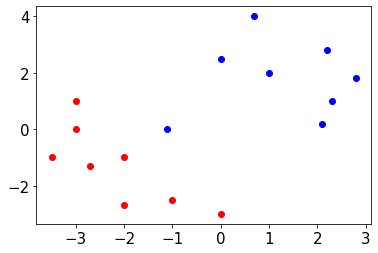

In [3]:
# Create Synthetic Data and visualize the points
X = np.array([[-3.5, -1], [-3, 0], [-3, 1], [-2.7, -1.3], [-2, -1], [-2, -2.7], 
              [-1, -2.5], [0, -3], [-1.1, 0], [0, 2.5], [1, 2], [0.7, 4], 
              [2.1, 0.2], [2.3, 1], [2.8, 1.8], [2.2, 2.8]])
y = np.array([1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1])

plot_points(X, y)
plt.show()

In the next cell you are required to derive the Quadratic Constrained Quadratic form of SVM **without soft constraints** from the basic principles. Start with the idea that SVM tries to maximize the margin and then derive the form which you can feed to the solver.

Please print the values of w, b. 

**Note: You are also required to upload a page of the derivation. You may also type it in markdown here.**

**Note: You cannot use sklearn SVM functions here.**

In [4]:
# Write your code here
def optimize(X, Y, svm_type = "hard", C = None):
    """Retrun the optimal parameters after solving an optimization problem 
    with a quadratic objective and affine equality and inequality constraints.
    X: Collection of all data points in matrix format. Row = record; column = feature.
    Y: Collection of Labels for all Data Samples.
    """
    # Number of unknown parameters.
    m, n = X.shape
    # define variable to optimize for.
    omega = cp.Variable((n, 1))
    beta0 = cp.Variable()
    if svm_type == "soft":
        epsilon = cp.Variable((m, 1))
        # Define problem.
        problem = cp.Minimize((1/2)*cp.quad_form(omega, np.eye(n)) + C*cp.sum(epsilon))
        # define constraints.
        constraints = [cp.multiply(((X @ omega) + beta0), Y.reshape(-1, 1)) >= (1 - epsilon), epsilon >= 0]
    else:
        # Define problem.
        problem = cp.Minimize((1/2)*cp.quad_form(omega, np.eye(n)))
        # define constraints.
        constraints = [cp.multiply(((X @ omega) + beta0), Y.reshape(-1, 1)) >= 1]
    # Construct the whole pipeline.
    prob = cp.Problem(problem, constraints)
    # solve and return the solutions...
    prob.solve()
    if svm_type == "soft":
        return prob.value, omega.value, beta0.value, epsilon.value
    return prob.value, omega.value, beta0.value

In [5]:
# Write your code here
class lagrange_optimizer:
    """Retrun the optimal parameters after solving an optimization problem 
    with a quadratic objective and affine equality and inequality constraints.
    X: Collection of all data points in matrix format. Row = record; column = feature.
    Y: Collection of Labels for all Data Samples.
    """
    def __init__(self, svm_type = "hard", C = None, tol = 1e-7):
        self.tol = tol
        self.svm_type = svm_type
        self.C = C
        
    def fit(self, X, Y):
        # Number of unknown parameters.
        m, n = X.shape
        # define variable to optimize for.
        alphas = cp.Variable((m, 1))
        # Define problem.
        beta = cp.sum(cp.multiply(alphas, X*Y.reshape(-1, 1)), axis = 0)
        problem = cp.Maximize((1/2)*cp.sum(alphas) - (1/2)*cp.quad_form(beta, np.eye(n)))
        if self.svm_type == "soft":
            # since alpha = C => inside margin and alpha < C => on margin
            constraints = [alphas >= 0, alphas <= self.C, alphas.T @ Y.reshape(-1, 1) == 0]
        else:
            constraints = [alphas >= 0, alphas.T @ Y.reshape(-1, 1) == 0]
        # Construct the whole pipeline.
        prob = cp.Problem(problem, constraints)
        # solve and return the solutions...
        prob.solve(solver = cp.ECOS)#solver=cp.SCIPY, scipy_options={"method": "highs"}
        # Store the optimal solution...
        self.solution = prob.value
        # Save the values of alpha...
        self.alphas_ = alphas.value
        # set the elements of alphas <= 1e-7 as 0.
        self.alphas_[self.alphas_ <= self.tol] = 0
        # Indices...
        idx = (self.alphas_.ravel())!=0
        # return support vectors.
        self.support_vectors_ = X[idx]
        # return support vectors on margin.
        #if self.svm_type == "soft":
        #    self.support_vectors_on_margin =\
        #    X[np.logical_and(self.alphas_.ravel() > 0, self.alphas_.ravel() < (self.C - self.tol))]
        # Support vectos labels.
        self.support_vector_labels_ = Y[idx]
        # Return Omega.
        self.omega = np.sum(self.alphas_[idx].reshape(-1, 1)*\
                            self.support_vectors_*self.support_vector_labels_.reshape(-1, 1), axis = 0)
        # Return bias.
        self.b = np.mean(self.support_vector_labels_ - np.dot(self.support_vectors_, self.omega))

**Derivation of Quadratic Constrained Quadratic form of SVM without soft constraints**

1. **SVM** is a supervised ML algorithm used for binary classification.
2. Using this algorithm we intend to find a "*hyperplane*" (or Decision Boundary) that satisfy the following:
    1. It creates a separation between examples of two classes with a maximum margin $\longrightarrow$ which we can see in objective.
    2. Following above, it's equation ($\omega^T x + \beta_0 = 0$) yields a value $\geq M$ (=margin, e.g., $M = 1$) for +ve class examples (having labels = +1) and $\leq -M$ for negative class examples (having labels = -1).
3. Say, we have data points with two features (2D data-points) having two labels: **+ve** and **-ve**. And suppose they are linearly separable with decision boundary (DB): $\omega^T x + \beta_0 = 0$. Now our ***objective*** is to find optimal values for $\omega$ and $\beta_0$ such that it able to separate +ve and -ve class with the largest margin.
4. Suppose, $M$ is the margin (or perpendicular distance) from the given DB with which we draw two more DBs (or fences) on either side of original DB. Then their equations are as follows:
    1. For DB1 (+ve class): $$\omega^T x + \beta_0 = M$$
    2. For DB2 (-ve class): $$\omega^T x + \beta_0 = -M$$ where $(-\beta_0) = $ distance of original DB from origin, while distance of DB1 from origin $= -\beta_0 + M$ and for DB2 its $= -\beta_0 - M$ if $\lVert \omega\rVert_2 = 1$. So formulating all the above, we got the following objective with some quadratic constraints.
5. Distance between fences $= (-\beta_0 + M) - (-\beta_0 - M) = 2M$. Since we need to maximize the fences width $\equiv$ maximixing margin $= M$ given that $\lVert \omega\rVert_2 = 1$ and $y_i(\omega^T x_i + \beta_0) \geq M\ \forall i = 1, \ldots, N$, our OBJECTIVE (or Cost Function) looks as: $$\max\limits_{\omega, \beta_0, M} M$$ subject to: $$\begin{align*}
& \sum\limits_{j=1}^{p}\omega_{i}^{2} = 1\ (\text{for unit vector case and here p=2})\\
& \text{and}\\
& y_i(\beta_0 + \omega_1 x_{i1} + \omega_2 x_{i2} + \ldots + \omega_p x_{ip}) \geq M\ \forall i = 1, \ldots, N
\end{align*}$$
6. For the case where $M = 1$ and $\lVert \omega\rVert_2 \neq 1$ with minor modifications and following along the same line our OBJECTIVE function looks as follows: $$\max\dfrac{2}{\lVert \omega\rVert_2} = \min \dfrac{1}{2}\omega^T\omega$$ subject to: $$\begin{align*}
& y_i(\beta_0 + \omega^T x_{i}) \geq 1\ \forall i = 1, \ldots, N
\end{align*}$$
7. **Lagrange Multiplier**: We can find the maximum or minimum of a multivariable function with some constraint using the *Lagrange Multiplier*. For inequality constraint, the **dual formulation** somewhat looks as follows:$$
\begin{align*}
&\max\limits_{x}f(x)\\
\text{s.t. } &g_i(x) \leq 0,\ \forall\ i = 1, \ldots, n\\
&h_j(x) = 0,\ \forall\ j = 1, \ldots, m\\
&\qquad \qquad \Bigg\downarrow\\
L(x, \alpha, \lambda) &= f(x) + \sum_{i=1}^{n}\alpha_i g_i(x) + \sum_{j=1}^{m}\lambda_j h_j(x) 
\end{align*}
$$
8. However, in order to find the solution for the variables, it wont be enough only to take the gradients and set those to zero due to the **Inequality Constraints**. Setting, $\Delta_{x, \lambda}L = 0$ still gives two of the conditions, but for the Inequality Constraint, we need to have 3 additional conditions. Hence instead of total 3, we will now have total 5 conditions.$$
\begin{align*}
\alpha_i g_i(x) &= 0,\ \forall\ i = 1, \ldots, n\\
g_i (x) &\leq 0,\ \forall\ i = 1, \ldots, n\\
\alpha_i &\geq 0,\ \forall\ i = 1, \ldots, n\\
\dfrac{\partial L}{\partial x_d} &= 0,\ \forall\ d = 1, \ldots, D\\
\dfrac{\partial L}{\partial \lambda_j} &= 0,\ \forall\ j = 1, \ldots, m
\end{align*}$$
9. These above 5 conditions are called **KKT (Karush-Kuhn-Tucker)** conditions and luckily they are also met for our Hard-Margin problem $\longrightarrow$ **Strong Duality** holds (i.e., $P^* - D^* = 0$).
10. Writing the expression obtained at **step 6** in form of *Lagrangian Multiplier*, we get: $$\min \dfrac{1}{2}\omega^T\omega$$ subject to: $$\begin{align*}
&\text{KKT condition 2: }\underbrace{1 - y_i(\beta_0 + \omega^T x_{i})}_{g_i (x)} \leq 0\ \forall i = 1, \ldots, N\\
&\text{KKT condition 1: }\alpha_i(1 - y_i(\beta_0 + \omega^T x_{i})) = 0\\
&\text{KKT condition 3: }\alpha_i \geq 0\\
&\text{KKT condition 4: }\dfrac{\partial L}{\partial \omega} = 0 \implies \omega = \sum_{i=1}^N\alpha_i y_i x_i\\
&\text{KKT condition 5: }\dfrac{\partial L}{\partial \beta_0} = 0 \implies \sum_{i=1}^N\alpha_i y_i = 0
\end{align*}$$ and $$\max_{\alpha} L_{dual} = \sum_{i=1}^N\alpha_i - \dfrac{1}{2}\omega^T\omega = \sum_{i=1}^N\alpha_i - \dfrac{1}{2}\sum_{i=1}^N\sum_{j=1}^N\alpha_i\alpha_j y_i y_j x_{i}^T x_j$$ which is a *convex quadratic programming problem* due to the $\alpha_i\alpha_j$ term and can be solved using `cvxpy` package.

In [6]:
# Run the simple optimization algorithm to obtain weights and biases.
cost_val, w, b = optimize(X, y)

In [7]:
print(f"The values of Omega: {w[0][0]}, {w[1][0]}\nand bias: {b} through simple convex optimization.")

The values of Omega: -1.7391304347826084, -1.3043478260869563
and bias: -2.91304347826087 through simple convex optimization.


In [8]:
# Run Lagrangian form of optimization algorithm to Obtain alphas.
lag_opt = lagrange_optimizer()
lag_opt.fit(X, y)

In [11]:
# Print the Omega and Bias.
print(f"The values of Omega: {lag_opt.omega[0]}, {lag_opt.omega[1]}\nand bias: {lag_opt.b} through Lagrangian convex optimization.")

The values of Omega: -0.8695653008549129, -0.6521740283949613
and bias: -1.2898552634316884 through Lagrangian convex optimization.


In the next cell you are required to visualize the boundary predicted by the solver. You may want to revise up on how to plot the a line given w, b. Please plot w vector as well as the margin lines

You may want to create a function to plot the line of separation as you would require this frequently in the subsequent parts of the assignment.

In [16]:
# Compute Distance between point and line...
def shortest_distance(point, line_param):
    """
    point: support vector point
    line_param: w0 (= 1st param), w1 (= 2nd param), and beta0 (=the intercept)
    """
    d = np.abs((line_param[0] * point[0] + line_param[1] * point[1] + line_param[2])) / (np.sqrt(line_param[0]**2 + line_param[1]**2))
    return d

# Write your code here
def plot_SVC(X, Y, w, b, margin = False, support_vectors = None, support_vectors_class = None):
    """SVC Classification plot."""
    # Convert the array into one dimensional array.
    w = w.ravel()
    # Store the data points in reds and blues.
    reds = []
    blues = []
    for i in range(len(Y)):
        if Y[i] == 1:
            reds.append(X[i])
        else:
            blues.append(X[i])
    reds = np.array(reds)
    blues = np.array(blues)
    # Define X-values.
    x_range = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    # Define x2 axis values.
    x2_vals = -(b + w[0]*x_range)/w[1]
    # margin = Boolean
    if margin:
        margin_width = -np.inf
        for support_point in support_vectors:
            dist = shortest_distance(support_point, [k for k in w]+[b])
            if dist > margin_width:
                margin_width = dist
        pos_x2 = (np.linalg.norm(w)*margin_width - (b + w[0]*x_range))/w[1]
        neg_x2 = (-np.linalg.norm(w)*margin_width - (b + w[0]*x_range))/w[1]
    else:
        pos_x2 = ((1/np.linalg.norm(w)) - (b + w[0]*x_range))/w[1]
        neg_x2 = (-(1/np.linalg.norm(w)) - (b + w[0]*x_range))/w[1]
    # Vector origin location
    X = [x_range[50]]
    Y = [x2_vals[50]]
    # Directional vectors
    U = [w[1]]
    V = [w[0]]
    # Creating plot
    plt.figure(figsize=(12, 10))
    plt.plot(x_range, x2_vals, color = 'g', linestyle = "-", label = "Classifier")
    plt.plot(x_range, pos_x2, color = 'r', linestyle = "--", label = "+ve Class Margin")
    plt.plot(x_range, neg_x2, color = 'b', linestyle = "--", label = "-ve Class Margin")
    plt.quiver(X, Y, U, V, color='k', units='xy', scale=1, label = "Normal Vector = w")
    plt.scatter(reds[:, 0], reds[:, 1], c = 'r', label = '+ve Class')
    plt.scatter(blues[:, 0], blues[:, 1], c = 'b', label = '-ve Class')
    if margin:
        plt.scatter(support_vectors[:, 0][support_vectors_class == 1],\
                    support_vectors[:, 1][support_vectors_class == 1],\
                    linewidths = 6, c="r", marker="^", label = "Support vectors")
        plt.scatter(support_vectors[:, 0][support_vectors_class == -1],\
                    support_vectors[:, 1][support_vectors_class == -1],\
                    linewidths = 6, c="b", marker="^", label = "Support vectors")
    plt.xlabel("x1"); plt.ylabel("x2"); plt.title("SVC Classification")
    plt.legend(loc = "best"); plt.grid(); plt.show()

https://www.tutorialspoint.com/how-to-plot-vectors-in-python-using-matplotlib

https://www.geeksforgeeks.org/how-to-plot-a-simple-vector-field-in-matplotlib/

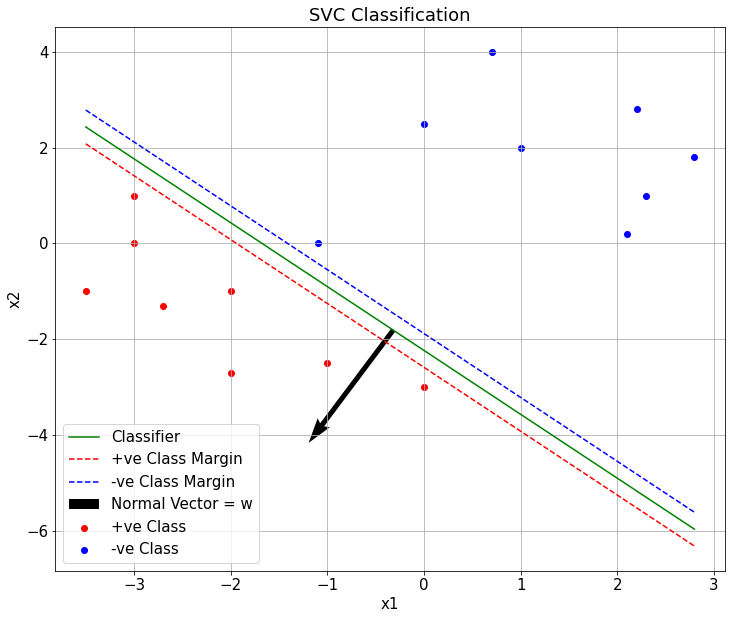

In [12]:
#Plot the SVC plot with Simple Optimization.
plot_SVC(X, y, w, b)

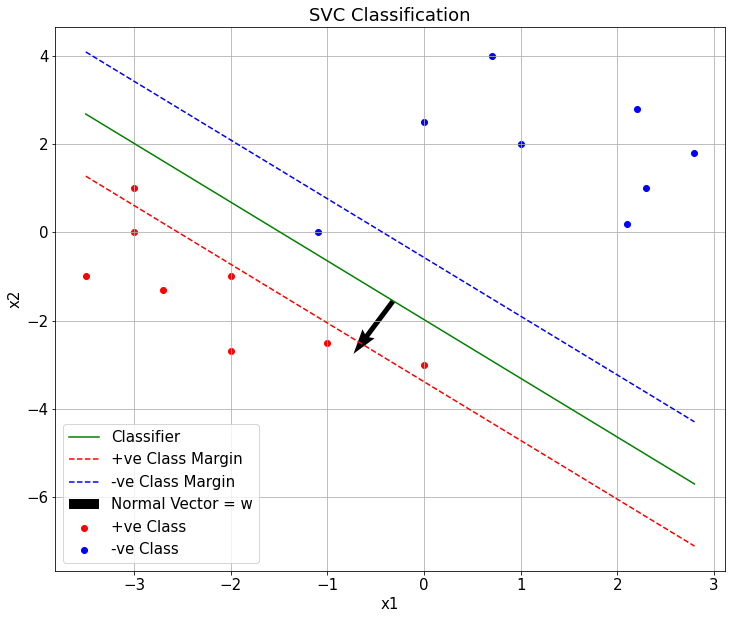

In [186]:
#Plot the SVC plot with Simple Optimization.
plot_SVC(X, y, lag_opt.omega, lag_opt.b)

1. **Seeing both the plots above, the previous plot is more significant than the later because the classifier is `equidistant` from support vectors on either side.**
2. **We can support vectors information from `lagrange_optimizer` class to compute the margin.**

In the next cell please plot only the support vectors along with the boundary, w vector, and margins. 

**Note: You are not supposed to hard-code the points here.**

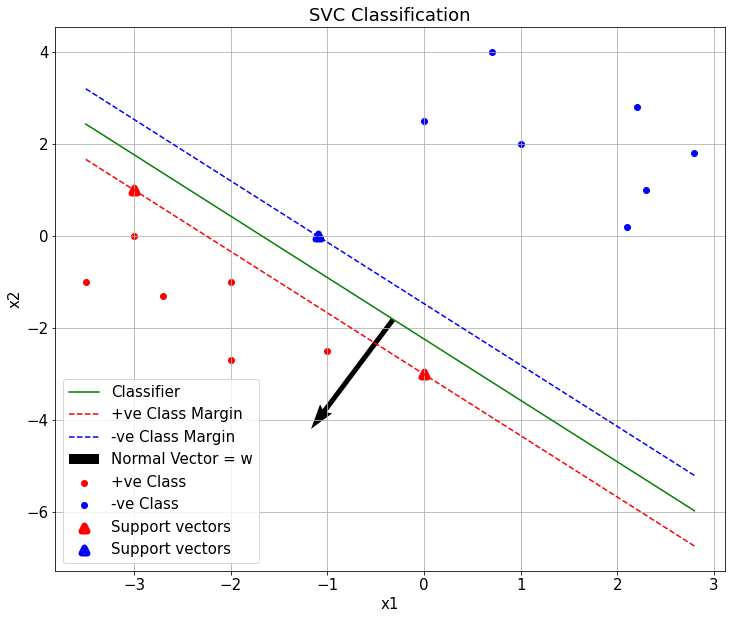

In [19]:
# Compute the margin length within the Plot function.
plot_SVC(X, y, w, b, margin = True, support_vectors = lag_opt.support_vectors_, support_vectors_class = lag_opt.support_vector_labels_)

In the next cell add the following points:
* (-4, -10) with label 1
* (4, 4) with label -1

Is the decision boundary changed after adding the points? Explain your observations theoretically.

In [21]:
# Re-create the Synthetic Data by adding the points and visualize the points
X_new = np.vstack((X, np.array([[-4, -10], [4, 4]])))
y_new = np.hstack((y, np.array([1, -1])))

In [22]:
# Solve for the decision boundary using this modified dataset
# Run the simple optimization algorithm to obtain weights and biases.
_, w_new, b_new = optimize(X_new, y_new)

In [23]:
print(f"The values of Omega: {w[0][0]}, {w[1][0]}\nand bias: {b} through simple convex optimization.")

The values of Omega: -1.7391304347826084, -1.3043478260869563
and bias: -2.91304347826087 through simple convex optimization.


In [24]:
# Run Lagrangian form of optimization algorithm to Obtain alphas.
lag_opt_new = lagrange_optimizer()
lag_opt_new.fit(X_new, y_new)

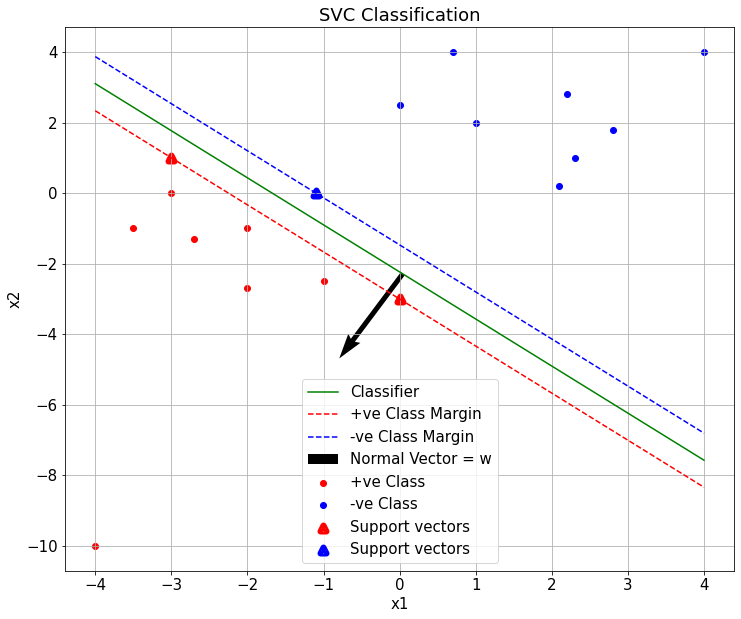

In [25]:
# Compute the margin length within the Plot function.
plot_SVC(X_new, y_new, w_new, b_new, margin = True, support_vectors = lag_opt_new.support_vectors_, support_vectors_class = lag_opt_new.support_vector_labels_)

In [134]:
# Print the suport vectors.
print("The New Support Vectors are:\n", lag_opt_new.support_vectors_)

The New Support Vectors are:
 [[-3.   1. ]
 [ 0.  -3. ]
 [-1.1  0. ]]


In [135]:
# Print the suport vectors.
print("The Old Support Vectors are:\n", lag_opt.support_vectors_)

The Old Support Vectors are:
 [[-3.   1. ]
 [ 0.  -3. ]
 [-1.1  0. ]]


**Observations:**

Since the new points added are not lying on **fences** of decision boundary (i.e., are not support vectors), the decision boundary as well as the fences remain the same.

In the next cell you are required to modify your framing of optimisation problem to incorporate soft constraints also known as slack. Plot the decision boundary, w and margin lines for various values of C: $0.01$, $0.1$, $3$, $10$, $100$.

Explain your results theoretically. How does the boundary change with varying values of C? Why?

**Note: Use the modified X and y i.e after adding points in previous cell.**

In [26]:
# Write your code here for C= 0.01

# Run the simple optimization algorithm to obtain weights and biases.
_, w_C1, b_C1, alpha_C1 = optimize(X_new, y_new, svm_type = "soft", C = 0.01)

# Run Lagrangian form of optimization algorithm to Obtain alphas.
lag_C1 = lagrange_optimizer(svm_type = "soft", C = 0.01)
lag_C1.fit(X_new, y_new)

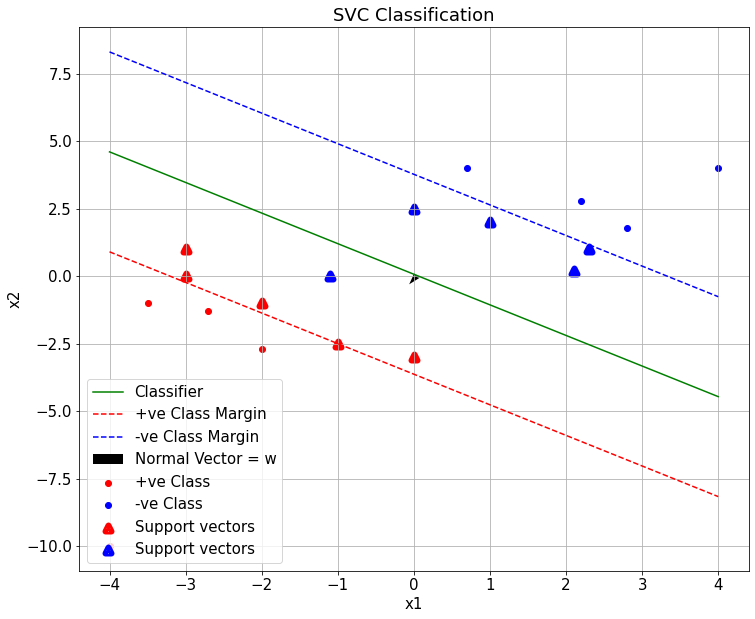

In [27]:
# Compute the margin length within the Plot function.
plot_SVC(X_new, y_new, w_C1, b_C1, margin = True, support_vectors = lag_C1.support_vectors_, support_vectors_class = lag_C1.support_vector_labels_)

In [29]:
# Write your code here for C= 0.1


# Run the simple optimization algorithm to obtain weights and biases.
_, w_C2, b_C2, alpha_C2 = optimize(X_new, y_new, svm_type = "soft", C = 0.1)

# Run Lagrangian form of optimization algorithm to Obtain alphas.
lag_C2 = lagrange_optimizer(svm_type = "soft", C = 0.1)
lag_C2.fit(X_new, y_new)

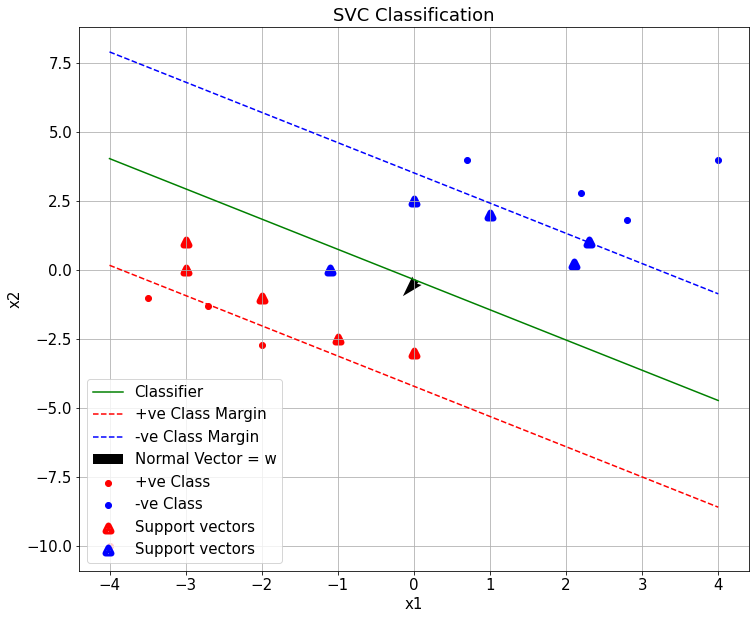

In [30]:
# Compute the margin length within the Plot function.
plot_SVC(X_new, y_new, w_C2, b_C2, margin = True, support_vectors = lag_C1.support_vectors_, support_vectors_class = lag_C1.support_vector_labels_)

In [31]:
# Write your code here for C= 3


# Run the simple optimization algorithm to obtain weights and biases.
_, w_C3, b_C3, alpha_C3 = optimize(X_new, y_new, svm_type = "soft", C = 3)

# Run Lagrangian form of optimization algorithm to Obtain alphas.
lag_C3 = lagrange_optimizer(svm_type = "soft", C = 3)
lag_C3.fit(X_new, y_new)

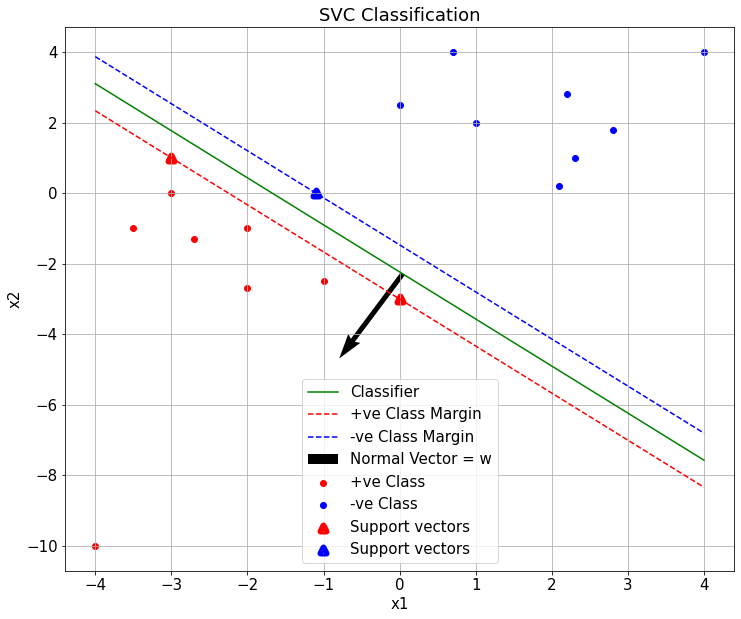

In [32]:
# Compute the margin length within the Plot function.
plot_SVC(X_new, y_new, w_C3, b_C3, margin = True, support_vectors = lag_C3.support_vectors_, support_vectors_class = lag_C3.support_vector_labels_)

In [33]:
# Write your code here for C= 10


# Run the simple optimization algorithm to obtain weights and biases.
_, w_C4, b_C4, alpha_C4 = optimize(X_new, y_new, svm_type = "soft", C = 10)

# Run Lagrangian form of optimization algorithm to Obtain alphas.
lag_C4 = lagrange_optimizer(svm_type = "soft", C = 10)
lag_C4.fit(X_new, y_new)

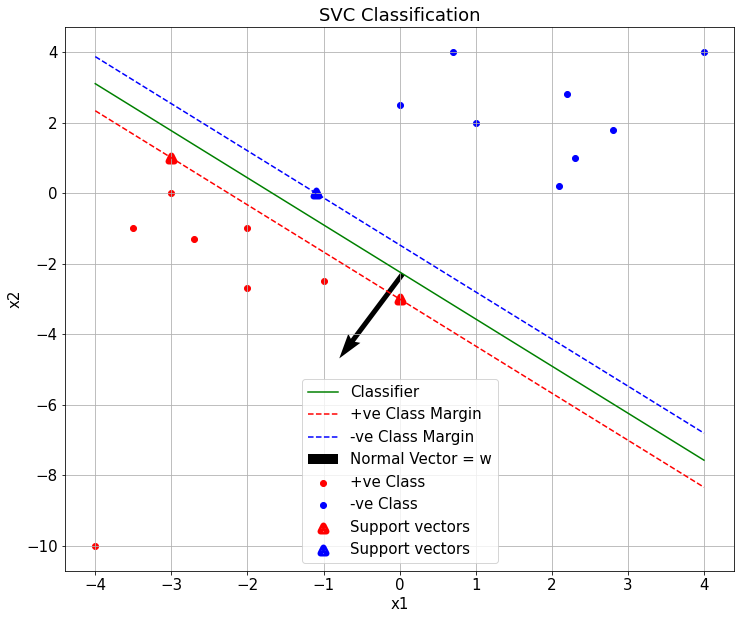

In [34]:
# Compute the margin length within the Plot function.
plot_SVC(X_new, y_new, w_C4, b_C4, margin = True, support_vectors = lag_C4.support_vectors_, support_vectors_class = lag_C4.support_vector_labels_)

In [35]:
# Write your code here for C= 100


# Run the simple optimization algorithm to obtain weights and biases.
_, w_C5, b_C5, alpha_C5 = optimize(X_new, y_new, svm_type = "soft", C = 100)

# Run Lagrangian form of optimization algorithm to Obtain alphas.
lag_C5 = lagrange_optimizer(svm_type = "soft", C = 100)
lag_C5.fit(X_new, y_new)

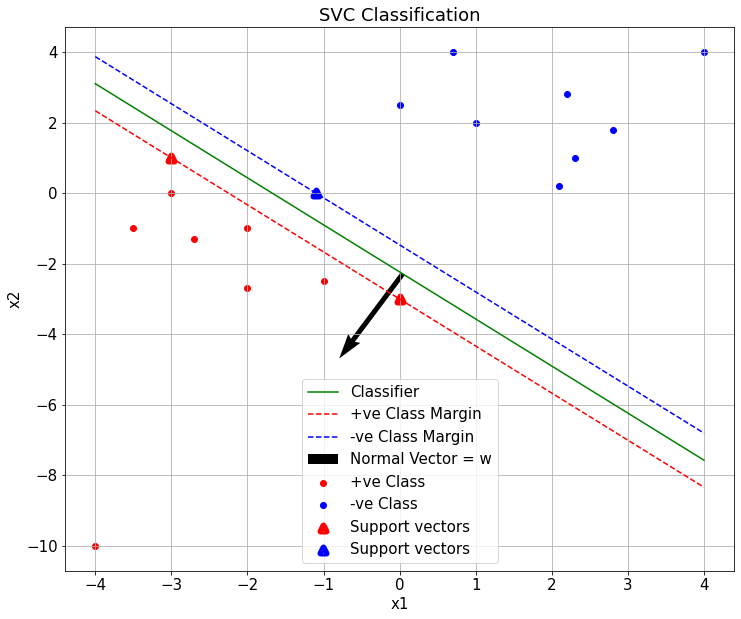

In [36]:
# Compute the margin length within the Plot function.
plot_SVC(X_new, y_new, w_C5, b_C5, margin = True, support_vectors = lag_C5.support_vectors_, support_vectors_class = lag_C5.support_vector_labels_)

**Why boundary changes with every value of $C$?**

**Answer:**
1. The $C$ parameter tells the SVC optimization how much you want to avoid misclassifying each training example.
2. $C$ parameter adds a penalty for each misclassified data point. Since it comes with `slack` variables in `soft-optimization`, increasing its value means penalizing the slack variabes to have larger values or in other sense penalty for allowing more number of points into the fences or say penalty for having large margin. As a result of which less mis-classification happens. For $C \longrightarrow\infty$, we have basically a **Hard-Margin Classifier**, which we can observe here, i.e., after $C=3$, since there are no data-points inside the fences, the **DB** and the **Margins** remains the same because they get defined through *support vectors*.
3. Likewise, if $C$ is small, the penalty for misclassified points is low so a DB with a large margin is chosen at the expense of a greater number of misclassifications.
4. Penalty is not same for all misclassified examples. It is directly proportional to the distance to decision boundary. 
5. For very tiny values of $C$, you should get misclassified examples, often even if your training data is linearly separable.

Take the case of C = 100 and remove the support vectors. Does the boundary change after the deletion?
Explain why? Show your results by appropriate plots?

In [37]:
# Write your Code here
def arr_check(arr, check_arr):
    for arr1 in check_arr:
        if np.array_equal(arr1, arr):
            return True
    return False
# Collect relevant data points.
_100 = [[arr, y] for arr, y in zip(X_new, y_new) if not arr_check(arr, lag_C5.support_vectors_)]
X_100 = np.array([arr[0] for arr in _100]); y_100 = np.array([arr[1] for arr in _100])

In [38]:
# Run the simple optimization algorithm to obtain weights and biases.
_, w_100, b_100, alpha_100 = optimize(X_100, y_100, svm_type = "soft", C = 100)

# Run Lagrangian form of optimization algorithm to Obtain alphas.
lag_100 = lagrange_optimizer(svm_type = "soft", C = 100)
lag_100.fit(X_100, y_100)

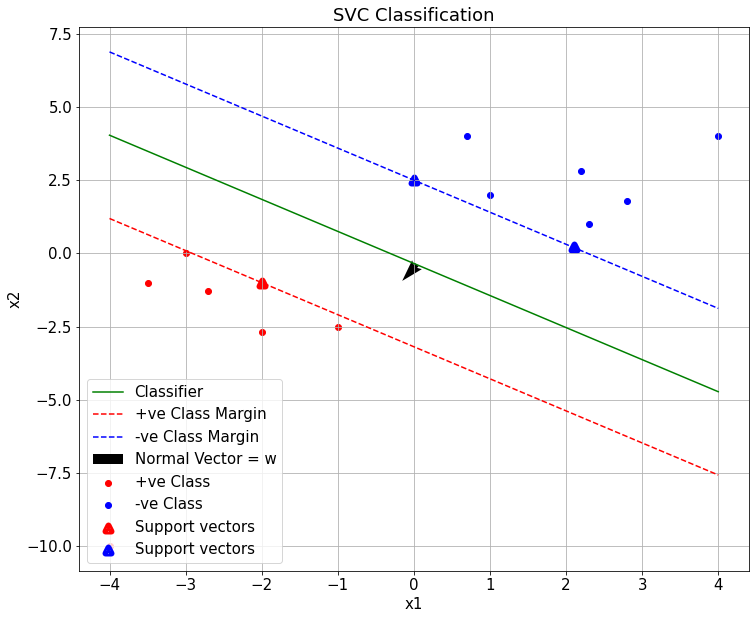

In [39]:
# Compute the margin length within the Plot function.
plot_SVC(X_100, y_100, w_100, b_100, margin = True, support_vectors = lag_100.support_vectors_, support_vectors_class = lag_100.support_vector_labels_)

**Why boundary Changes?**

**Answer:**
1. As we have discussed above that $\omega = $ normal vector and $b = $ the bias (or intercept) of DB is directly linked with support-vectors and their labels, removing them would surely affect the boundary.
2. $\omega = \sum\limits_{\alpha_i > 0}\alpha_i y_i x_i$, and $b = \text{avg}_{\alpha_i > 0}(y_i - \omega^{T}x_i)$ where $\alpha_i > 0$ denotes the support-vectors.
3. Removing the initial support vectors, forces SVM algo to estimate DB between two classes on the basis of nearest data-points on either side. So on the basis of how margins are getting leaned on nearest data-points from potential DB, the final DB is nothing but the mid-line between those margins or fences.

### Subsection 2

In [1]:
!pip install python-mnist
!rm -rf samples
!mkdir samples
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -P samples/
!gunzip samples/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -P samples/
!gunzip samples/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -P samples/
!gunzip samples/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -P samples/
!gunzip samples/t10k-labels-idx1-ubyte.gz

--2021-11-21 02:58:55--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘samples/train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2021-11-21 02:58:55 (90.6 MB/s) - ‘samples/train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2021-11-21 02:58:56--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘samples/train-labels-idx1-ubyte.gz’

train-labe

In [1]:
# Import Relevant Packages
from sklearn.svm import SVC
import numpy as np
from mnist.loader import MNIST
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import seaborn as sns
from sklearn import model_selection
import matplotlib.pyplot as plt

In [2]:
mndata = MNIST('samples')

# Load training dataset
images, labels = mndata.load_training()
l = len(labels)
images_train = np.array(images)
labels_train = np.array(labels)

print(images_train.shape)
print(labels_train.shape)

(60000, 784)
(60000,)


In [3]:
# Load testing dataset
images, labels = mndata.load_testing()
l = len(labels)
images_test = np.array(images)
labels_test = np.array(labels)

print(images_test.shape)
print(labels_test.shape)

(10000, 784)
(10000,)


- Tweak different parameters like the C Parameter and gamma parameter of the Linear SVM and report the results.
- Experiment different kernels for classification and report the results.

Report accuracy score, F1-score, Confusion matrix and any other metrics you feel useful.

In [11]:
#report the required results on the model predictions
def results_report(y_pred,y_test):
    print(metrics.classification_report(y_test, y_pred))
    plt.figure(figsize = (7, 12))
    mat = metrics.confusion_matrix(labels_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=[0,1,2,3,4,5,6,7,8,9], yticklabels=[0,1,2,3,4,5,6,7,8,9])
    plt.xlabel('true label')
    plt.ylabel('predicted label');

In [5]:
#Taking top 300 Prnicpal Components to reduce the dimensionality of the data
pca = PCA(n_components=300, whiten=True, random_state=1)
images_train_pca = pca.fit_transform(images_train)
#print(np.cumsum(pca.explained_variance_ratio_))

**$\mathbf{C = 0.001}$**

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.91      0.92      1032
           3       0.93      0.92      0.92      1010
           4       0.91      0.95      0.93       982
           5       0.91      0.90      0.90       892
           6       0.95      0.95      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.90      0.90      0.90       974
           9       0.93      0.91      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



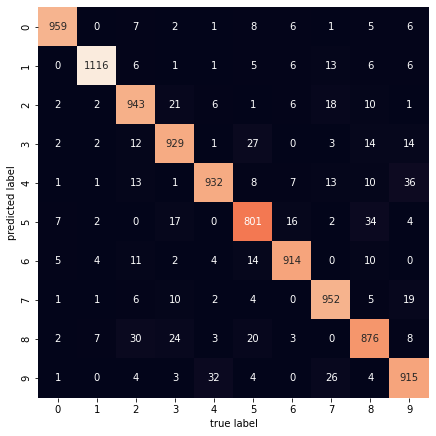

In [12]:
#fitting the Linear SVC model

# 1) Fitting linear SVM with C = 0.001
svc = SVC(kernel='linear', C = 0.001, random_state = 7)
model = svc.fit(images_train_pca,labels_train)
images_test_pca = pca.transform(images_test)
y_pred = model.predict(images_test_pca)
results_report(y_pred, labels_test)

**$\mathbf{C = 0.01}$**

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.94      0.93      0.93      1032
           3       0.91      0.93      0.92      1010
           4       0.94      0.96      0.95       982
           5       0.92      0.90      0.91       892
           6       0.96      0.96      0.96       958
           7       0.95      0.94      0.95      1028
           8       0.93      0.90      0.91       974
           9       0.94      0.92      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



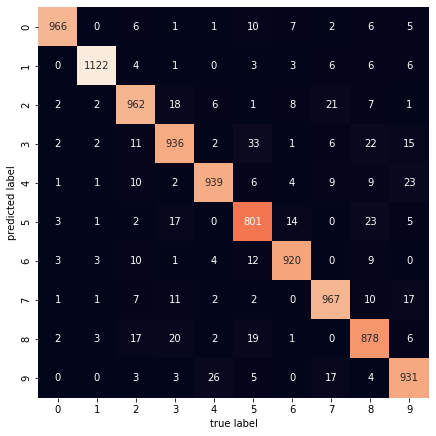

In [13]:
# 2) Fitting linear SVM with C = 0.01 
svc = SVC(kernel='linear', C = 0.01, random_state = 7)
model = svc.fit(images_train_pca,labels_train)
images_test_pca = pca.transform(images_test)
y_pred = model.predict(images_test_pca)
results_report(y_pred, labels_test)

**$\mathbf{C = 0.1}$**

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.99      0.98      1135
           2       0.93      0.94      0.93      1032
           3       0.90      0.94      0.92      1010
           4       0.93      0.95      0.94       982
           5       0.92      0.90      0.91       892
           6       0.96      0.95      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.93      0.90      0.92       974
           9       0.95      0.91      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



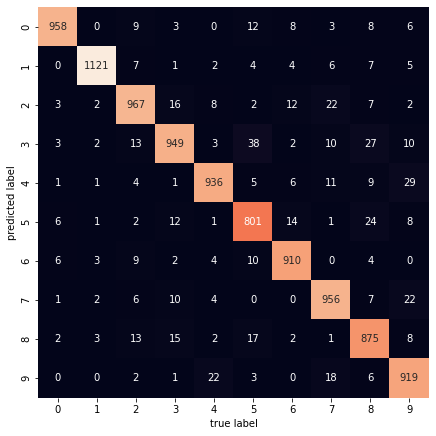

In [14]:
# 3) Fitting linear SVM with C = 0.1
svc = SVC(kernel='linear', C = 0.1, random_state = 7)
model = svc.fit(images_train_pca,labels_train)
images_test_pca = pca.transform(images_test)
y_pred = model.predict(images_test_pca)
results_report(y_pred, labels_test)

**$\mathbf{C = 1}$**

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.94      0.93      1032
           3       0.90      0.93      0.92      1010
           4       0.92      0.96      0.94       982
           5       0.91      0.89      0.90       892
           6       0.97      0.95      0.96       958
           7       0.94      0.92      0.93      1028
           8       0.92      0.89      0.91       974
           9       0.95      0.89      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



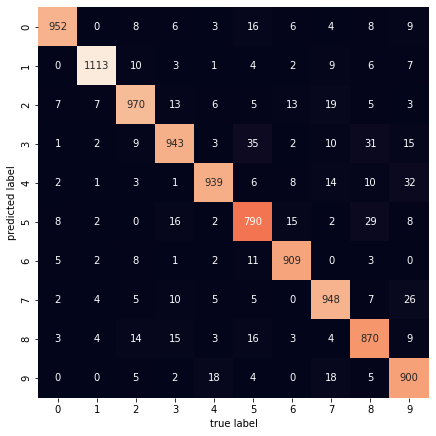

In [15]:
# 4) Fitting linear SVM with C = 1
svc = SVC(kernel='linear', C = 1, random_state = 7)
model = svc.fit(images_train_pca,labels_train)
images_test_pca = pca.transform(images_test)
y_pred = model.predict(images_test_pca)
results_report(y_pred, labels_test)

**RBF (Radial Basis Function) Kernel**

              precision    recall  f1-score   support

           0       0.93      0.41      0.57       980
           1       0.99      0.94      0.97      1135
           2       0.18      0.95      0.31      1032
           3       0.67      0.49      0.56      1010
           4       0.89      0.45      0.60       982
           5       1.00      0.05      0.10       892
           6       0.99      0.39      0.56       958
           7       0.93      0.58      0.72      1028
           8       0.77      0.21      0.33       974
           9       0.92      0.56      0.69      1009

    accuracy                           0.52     10000
   macro avg       0.83      0.50      0.54     10000
weighted avg       0.83      0.52      0.55     10000



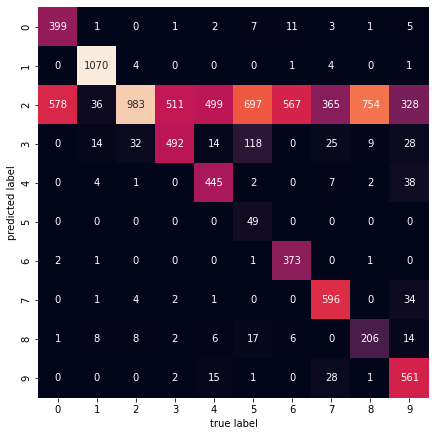

In [16]:
#Experimenting with different kernels

#1) RBF kernel
svc = SVC(kernel='rbf', C = 0.1, gamma = 0.01, random_state = 7)
model = svc.fit(images_train_pca,labels_train)
images_test_pca = pca.transform(images_test)
y_pred = model.predict(images_test_pca)
results_report(y_pred, labels_test)

**Polynomial Kernel**

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.91      0.99      0.95      1135
           2       0.98      0.90      0.94      1032
           3       0.92      0.97      0.94      1010
           4       0.95      0.95      0.95       982
           5       0.96      0.93      0.94       892
           6       0.97      0.96      0.97       958
           7       0.96      0.93      0.94      1028
           8       0.97      0.91      0.94       974
           9       0.92      0.95      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



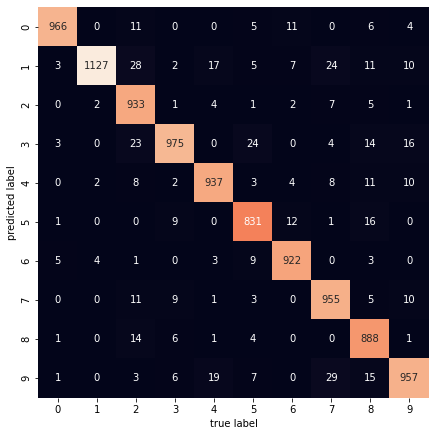

In [17]:
#2) Polynomial kernel
svc = SVC(kernel='poly', C = 0.1, gamma = 0.01, random_state = 7)
model = svc.fit(images_train_pca,labels_train)
images_test_pca = pca.transform(images_test)
y_pred = model.predict(images_test_pca)
results_report(y_pred, labels_test)

**Sigmoid Kernel**

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       980
           1       0.92      0.97      0.94      1135
           2       0.85      0.81      0.83      1032
           3       0.85      0.85      0.85      1010
           4       0.87      0.90      0.88       982
           5       0.78      0.81      0.80       892
           6       0.87      0.87      0.87       958
           7       0.89      0.87      0.88      1028
           8       0.83      0.79      0.81       974
           9       0.86      0.86      0.86      1009

    accuracy                           0.87     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.87      0.87      0.87     10000



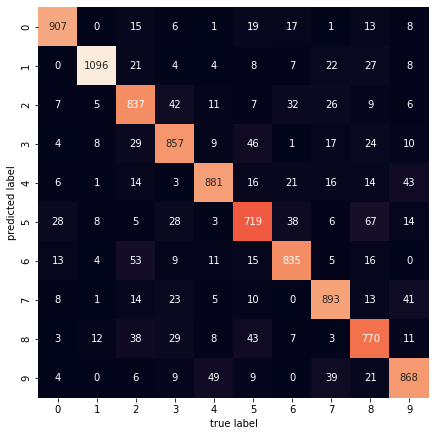

In [18]:
#3) Sigmoid kernel
svc = SVC(kernel='sigmoid', C = 0.1, gamma = 0.01, random_state = 7)
model = svc.fit(images_train_pca,labels_train)
images_test_pca = pca.transform(images_test)
y_pred = model.predict(images_test_pca)
results_report(y_pred, labels_test)

##### Rough